## Import libraries

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1
    !pip install keras_cv

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1M1TW6PTeAUJgqEz6TK_sPPBirCoPACP_/Homework 1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.9 MB/s eta 0:00:00


## Import preprocessed data

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras_cv

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


### Utils functions

In [ ]:
from datetime import datetime, timedelta
def time():
    if IN_COLAB:
        return datetime.now() + timedelta(hours=1)
    else:
        return datetime.now()

# Function to stringify the layer configurations
def stringify_augmentation(augmentation_pipeline):
    layer_descriptions = []
    for layer in augmentation_pipeline.layers:
        layer_name = layer.__class__.__name__
        # Filter out only essential parameters
        essential_params = {k: v for k, v in layer.get_config().items() if k in ["mode", "height_factor", "width_factor", "factor", "fill_mode", "interpolation"]}
        layer_desc = f"{layer_name}(" + ", ".join(f"{k}={v}" for k, v in essential_params.items()) + ")"
        layer_descriptions.append(layer_desc)
    return "[" + ", ".join(layer_descriptions) + "]"

In [ ]:
X, y = np.load('Preprocessed_data/X.npy'), np.load('Preprocessed_data/y.npy')
# convert y to 1D array
y = y.squeeze()

class_names = np.load('Preprocessed_data/class_names.npy')
print(X.shape, y.shape)
print(class_names)

(11959, 96, 96, 3) (11959,)
['class_0' 'class_1' 'class_2' 'class_3' 'class_4' 'class_5' 'class_6'
 'class_7']


### Plot distribution of classes

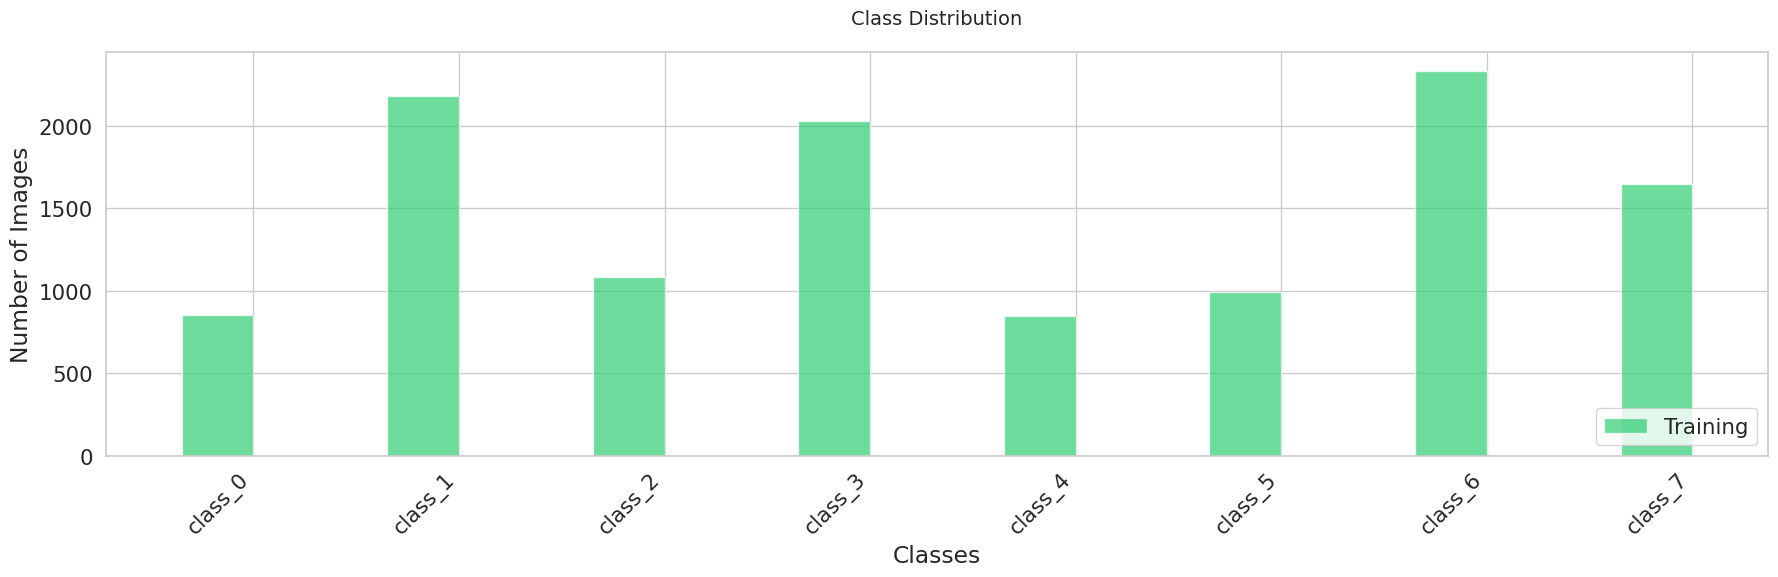

In [ ]:
def plot_class_distribution(y_train, class_names):
    # Set seaborn style for the plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Calculate class distributions for training and test sets
    train_dist = np.bincount(y_train)


    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#2ecc71', alpha=0.7)

    # Customise plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# Execute function to plot class distribution
plot_class_distribution(y, class_names)

## Generate validation split(s)

In [ ]:
# Split validation set into validation and test sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=y)

# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (9567, 96, 96, 3), y_train shape: (9567, 8)
X_val shape: (2392, 96, 96, 3), y_val shape: (2392, 8)


## Optionally use Weighted loss
we can avoid setting this parameter in the training function if we don't want to weight the loss

In [ ]:
class_counts = np.bincount(np.argmax(y_train, axis=1))  # Conta le occorrenze per ogni classe
total_samples = len(y_train)

# Calcola i pesi delle classi come frequenza inversa
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
print("Class weights:", class_weights)

Class weights: {0: 1.753482404692082, 1: 0.6853151862464183, 2: 1.3777361751152073, 3: 0.7377390499691548, 4: 1.7612297496318114, 5: 1.506139798488665, 6: 0.6415638412017167, 7: 0.9101027397260274}


## Define a Model

In [ ]:
# Set some variables for convenience to refer to the chosen architecture

NET_NAME = 'EfficientNetB4'
# (OPTIONAL) this will be added to the model name to identify the run in the folder, logs...
IDENTIFIER = ""
MODEL_NAME = NET_NAME + ("_" + IDENTIFIER if IDENTIFIER else "")

# this will be added as a file in the model folder to describe the run
RUN_DESCRIPTION = "abbiamo scelto efficientnetb4 come modello, abbiamo fatto questa scelta per questo motivo ecc ecc"

# Set the hyperparameters (this metrics will be saved with the weights)
# These refers specifically to the first run (transfer learning)
hyperparameters = {
    'batch_size': 256,
    'epochs': 200,
    'lr': 0.001,
    'weight_decay': 0.001,#0.001,
    'patience': 10,
    'optimizer': 'adam', # to change manually from here if needed
    'weighted_loss': True,
    'label_smoothing': 0.1, # set None to deactivate
    'mixup': False,
    'mixup_alpha': 0.2,
    'mixup_prob': 0.5,
    'transfer_learning': 'full'
}

### Select a pretrained network from keras.application and optionally display it (showing number of layers, parameters etc)

In [ ]:


# Initialise chosen model with pretrained weights, for transfer learning
net = tfk.applications.EfficientNetB4(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',#mettere image net, prima era none
    pooling='avg'
)

# Display a summary of the model architecture
#net.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(net, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Choose augmentation layer

In [ ]:
import keras_cv
# Apply data augmentation for training robustness
"""
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomTranslation(0.3, 0.3),
    tfkl.RandomRotation(0.5),
    tfkl.RandomZoom(0.4),
    tfkl.RandomContrast(0.7),
    tfkl.RandomBrightness(0.4),
    keras_cv.layers.RandomSharpness(factor=(0.3, 0.8), value_range=(0, 255)),
    tfkl.GaussianNoise(stddev=0.1),
    #keras_cv.layers.RandomChannelShift(value_range=(0, 255), factor=0.05, channels=3),
    #keras_cv.layers.RandomColorDegeneration(factor=0.1),
    keras_cv.layers.RandomSaturation(factor=0.05),
    #keras_cv.layers.RandomHue(factor=0.05, value_range=(0, 255)),
    keras_cv.layers.RandomContrast(factor=0.05, value_range=(0, 255)),
    #keras_cv.layers.Solarization(value_range=(0, 255), addition_factor=0.0, threshold_factor=0.2)

], name='preprocessing')
"""

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128

IMAGE_SIZE = 96
"""
layers = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3, magnitude=0.5
)
"""
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    return {"images": image, "labels": label}

layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.3, magnitude_stddev=0.3
)

layers = layers + [keras_cv.layers.GridMask()]

random_pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=layers, augmentations_per_image=3
)
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp(alpha=0.2)

def cutmix_and_mixup(X, y):
  # we must convert to a dictionary to apply these transfromations
  X = to_dict(X, y)
  #X = cut_mix(X)
  X = mix_up(X)
  return X['images'], X['labels']

train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (random_pipeline(tf.cast(x, tf.uint8)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (cutmix_and_mixup(x, y)),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (random_pipeline(tf.cast(x, tf.uint8)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)




# Visualize examples of augmented images
def visualize_augmented_images(image, augmentation):
    # plot original image together with other 8 versions of the same image, in the same plot
    fig, ax = plt.subplots(3, 3, figsize=(20, 20))
    ax = ax.ravel()
    ax[0].imshow(np.array(image, dtype='uint8'))
    ax[0].set_title('Original image')
    ax[0].axis('off')
    for i in range(1, 9):
        augmented_image = augmentation(tf.expand_dims(image, 0))

        ax[i].imshow(np.array(augmented_image[0], dtype='uint8'))
        ax[i].set_title(f'Augmented image {i}')
        ax[i].axis('off')



"""# Load some example image stratified by class
indexes = [np.where(np.argmax(y_train, axis=1) == i)[0][0] for i in range(len(class_names))]
indexes = np.random.choice(indexes, 3)
example_images = X_train[indexes]
# Visualize augmented images
for i in range(len(indexes)):
    visualize_augmented_images(example_images[i], augmentation)"""




'# Load some example image stratified by class\nindexes = [np.where(np.argmax(y_train, axis=1) == i)[0][0] for i in range(len(class_names))]\nindexes = np.random.choice(indexes, 3)\nexample_images = X_train[indexes]\n# Visualize augmented images\nfor i in range(len(indexes)):\n    visualize_augmented_images(example_images[i], augmentation)'

### Add mixup images generator to include mixed up images (not a layer, but a preprocessing at batch generator level)

In [ ]:
from tensorflow.keras.utils import Sequence

# Converti le etichette in float32 per essere compatibili con MixUp
y_train = tf.cast(y_train, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)

# Generatore di dati personalizzato con MixUp applicato parzialmente
class PartialMixupDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=64, mixup_alpha=0.2, mixup_prob=0.5, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.mixup = keras_cv.layers.MixUp(alpha=mixup_alpha)
        self.mixup_prob = mixup_prob  # Probabilità di applicare MixUp
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        # Estrai un batch di indici
        batch_indices = tf.constant(self.indices[index * self.batch_size:(index + 1) * self.batch_size])
        batch_images = tf.gather(self.images, batch_indices)
        batch_labels = tf.gather(self.labels, batch_indices)

        # Applica MixUp solo con una certa probabilità
        if np.random.rand() < self.mixup_prob:
            mixed_data = self.mixup({'images': batch_images, 'labels': batch_labels})
            batch_images, batch_labels = mixed_data['images'], mixed_data['labels']

        return batch_images, batch_labels  # Ritorna batch mixato/non-mixato

    def on_epoch_end(self):
        # Mescola i dati a fine epoca se shuffle è True
        self.indices = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indices)

if hyperparameters['mixup']:
    # Crea un'istanza del generatore di dati
    train_generator = PartialMixupDataGenerator(
        images=X_train,
        labels=y_train,
        batch_size=hyperparameters['batch_size'],
        mixup_alpha=hyperparameters['mixup_alpha'],
        mixup_prob=hyperparameters['mixup_prob']
    )

### Fully visualize the crap we are feeding into the network

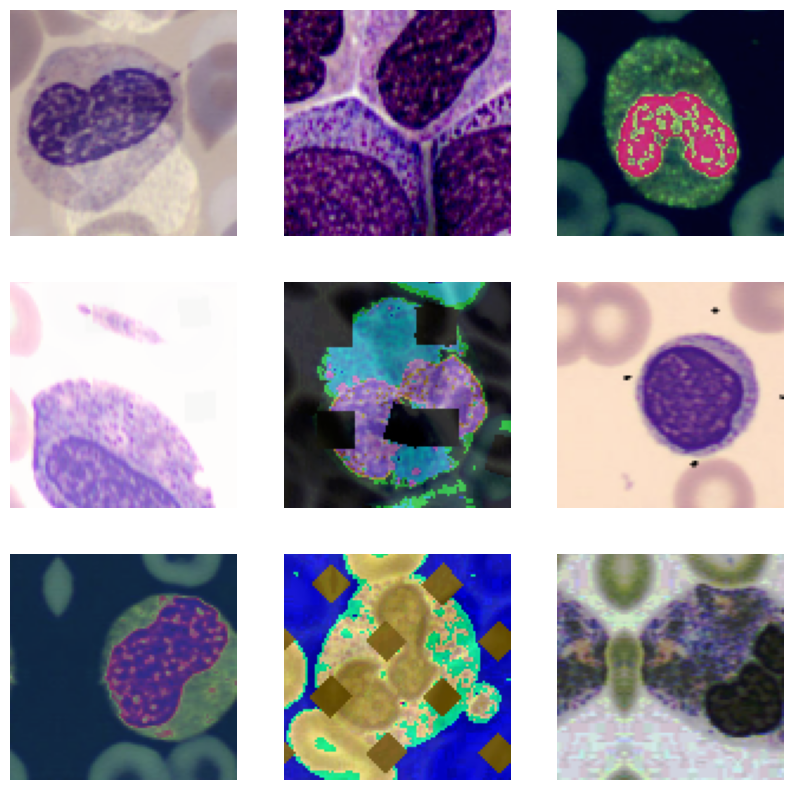

In [ ]:
# Visualize some example of a batch with MixUp applied, and also augmented
if hyperparameters['mixup']:
    # Estrai un batch di immagini e etichette
    batch_images, batch_labels = train_generator[8]
    # Visualizza le immagini del batch
    for i in range(len(batch_images[:3])):
        visualize_augmented_images(batch_images[i], augmentation)
else:
    sample_images, _ = next(iter(train_ds_rand))
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(sample_images[:9]):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image.numpy().astype("int"))
      plt.axis("off")

OPTIMIZER

In [ ]:
# Early stopping helps as it stops training if val_loss(validation score) does not decrease.
"""
!pip install tensorflow_addons
import tensorflow_addons as tfa


lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100, decay_rate=0.96,
    staircase=True)


def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim
"""



'\n!pip install tensorflow_addons\nimport tensorflow_addons as tfa\n\n\nlr_schedule = ExponentialDecay(\n    initial_learning_rate=1e-3,\n    decay_steps=100, decay_rate=0.96,\n    staircase=True)\n\n\ndef Ranger(sync_period=6,\n           slow_step_size=0.5,\n           learning_rate=0.001,\n           beta_1=0.9,\n           beta_2=0.999,\n           epsilon=1e-7,\n           weight_decay=0.,\n           amsgrad=False,\n           sma_threshold=5.0,\n           total_steps=0,\n           warmup_proportion=0.1,\n           min_lr=0.,\n           name="Ranger"):\n    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)\n    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)\n    return optim\n'

In [ ]:
from tensorflow.keras.optimizers import Lion
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100, decay_rate=0.96,
    staircase=True)

optimizer = Lion(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.99,
    weight_decay=1e-2,
    use_ema=False  # Setta True se vuoi usare EMA, ma normalmente è disattivato per Lion
)




### Add preprocessing and augmentation layers to the initial stage of the model ("in front" of the selected network)

In [ ]:

from tensorflow.keras.applications.efficientnet import preprocess_input



# Freeze all layers in net to use it solely as a feature extractor
net.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

#x = preprocess_input(inputs)
x = tfkl.GaussianNoise(stddev=0.1)(inputs)
#x = augmentation(x)
#x = augmentation(inputs)
x = net(x)
# Pass augmented inputs through the network feature extractor
#x = net(x)

#see if it's necessary to add a dense layer, in general is added in this part
#x = tfkl.Dense(256, activation='relu')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)


# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', dtype='float32', name='output')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=hyperparameters['label_smoothing']), optimizer=tfk.optimizers.Adam(hyperparameters["lr"], weight_decay=hyperparameters['weight_decay']), metrics=['accuracy'])#optimizer=tfk.optimizers.Adam(hyperparameters["lr"], weight_decay=hyperparameters['weight_decay'])

# Display a summary of the model architecture
#tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## Train the model

### First we use transfer learning

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_rand,
    batch_size=(hyperparameters['batch_size'] if not hyperparameters['mixup'] else None),
    epochs=hyperparameters['epochs'],
    validation_data=val_ds,
    class_weight=(class_weights if hyperparameters['weighted_loss'] else None),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=hyperparameters['patience'], restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
run_dir_name = MODEL_NAME + "_" + str(final_val_accuracy) + "__" + time().strftime("_%Y-%m-%d_%H.%M")
model_filename = 'weights.keras'
os.makedirs("weights/transfer_learning/"+ run_dir_name, exist_ok=True)
model_filepath = "weights/transfer_learning/"+ run_dir_name + "/" + model_filename
tl_model.save(model_filepath)

# Free memory by deleting the model instance
del tl_model

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 105s 767ms/step - accuracy: 0.2563 - loss: 1.9779 - val_accuracy: 0.6610 - val_loss: 1.3772
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.4477 - loss: 1.7180 - val_accuracy: 0.6890 - val_loss: 1.2798
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.4866 - loss: 1.6499 - val_accuracy: 0.7174 - val_loss: 1.1959
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.5038 - loss: 1.6057 - val_accuracy: 0.7320 - val_loss: 1.1740
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - accuracy: 0.5077 - loss: 1.6009 - val_accuracy: 0.7320 - val_loss: 1.1573
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 255ms/step - accuracy: 0.5320 - loss: 1.5593 - val_accuracy: 0.7395 - val_loss: 1.1190
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 256ms/step - accuracy: 0.5335 - loss: 1.5661 - val_accuracy: 0.7517 - val_loss: 1.1158
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - accuracy: 0.5458 - loss: 1.5416 -

In [ ]:
# store information about the run
with open("weights/transfer_learning/"+ run_dir_name + "/hyperparameters.txt", "w") as file:
    file.write(f"Hyperparameters:\n{hyperparameters}\n\n")
    file.write(f"Final validation accuracy: {final_val_accuracy}%\n\n")
    file.write(f"Run description: {RUN_DESCRIPTION}\n\n")

### Then fine-tune the model

In [ ]:
# Some hyperparameters may be changed or added for fine-tuning

hyperparameters['transfer_learning'] = 'fine_tuning'
hyperparameters['n_layers_frozen'] = 124
# optionally change the learning rate for fine tuning
hyperparameters['lr'] = 1e-4

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model(model_filepath, compile=False)


# Compila di nuovo il modello
ft_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Select trainable layers

In [ ]:
model_custom_layer = "efficientnetb4" # CHANGE THIS WITH THE MODEL

# Set the model layers as trainable
ft_model.get_layer(model_custom_layer).trainable = True

# Set all layers as non-trainable
for layer in ft_model.get_layer(model_custom_layer).layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers (THERE COULD BE DIFFERENT CHOICES IN OTHER MODELS)
for i, layer in enumerate(ft_model.get_layer(model_custom_layer).layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

5 stem_conv Conv2D True
8 block1a_dwconv DepthwiseConv2D True
13 block1a_se_reduce Conv2D True
14 block1a_se_expand Conv2D True
16 block1a_project_conv Conv2D True
18 block1b_dwconv DepthwiseConv2D True
23 block1b_se_reduce Conv2D True
24 block1b_se_expand Conv2D True
26 block1b_project_conv Conv2D True
30 block2a_expand_conv Conv2D True
34 block2a_dwconv DepthwiseConv2D True
39 block2a_se_reduce Conv2D True
40 block2a_se_expand Conv2D True
42 block2a_project_conv Conv2D True
44 block2b_expand_conv Conv2D True
47 block2b_dwconv DepthwiseConv2D True
52 block2b_se_reduce Conv2D True
53 block2b_se_expand Conv2D True
55 block2b_project_conv Conv2D True
59 block2c_expand_conv Conv2D True
62 block2c_dwconv DepthwiseConv2D True
67 block2c_se_reduce Conv2D True
68 block2c_se_expand Conv2D True
70 block2c_project_conv Conv2D True
74 block2d_expand_conv Conv2D True
77 block2d_dwconv DepthwiseConv2D True
82 block2d_se_reduce Conv2D True
83 block2d_se_expand Conv2D True
85 block2d_project_conv Con

In [ ]:

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer(model_custom_layer).layers[:hyperparameters['n_layers_frozen']]):
    layer.trainable = False#prima parte non trainable

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('efficientnetb4').layers):
    print(i, layer.name, layer.trainable)#last part to retrain

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

In [ ]:
# Cambia epsilon solo nei livelli sbloccati
for layer in ft_model.get_layer(model_custom_layer).layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization) and layer.trainable:
        layer.epsilon = 1e-3  # Aumenta epsilon solo nei BatchNorm attivi


In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=hyperparameters['label_smoothing']), optimizer=tfk.optimizers.Adam(hyperparameters["lr"], weight_decay=hyperparameters['weight_decay']), metrics=['accuracy'])

training

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_ds_rand,
    batch_size=(hyperparameters['batch_size'] if not hyperparameters['mixup'] else None),
    epochs=hyperparameters['epochs'],
    validation_data=val_ds,
    class_weight=(class_weights if hyperparameters['weighted_loss'] else None),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=hyperparameters['patience'], restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
run_dir_name = MODEL_NAME + str(final_val_accuracy) + "__" + time().strftime("_%Y-%m-%d_%H.%M")
model_filename = 'weights.keras'
os.makedirs("weights/"+ run_dir_name, exist_ok=True)
ft_model_filepath = "weights/"+ run_dir_name + "/" + model_filename
ft_model.save(ft_model_filepath)

# Delete the model to free up resources
#del ft_model

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 904ms/step - accuracy: 0.6102 - loss: 1.4243 - val_accuracy: 0.9239 - val_loss: 0.7001
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 341ms/step - accuracy: 0.7791 - loss: 1.1312 - val_accuracy: 0.9419 - val_loss: 0.6347
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 342ms/step - accuracy: 0.8274 - loss: 1.0364 - val_accuracy: 0.9594 - val_loss: 0.5877
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 339ms/step - accuracy: 0.8404 - loss: 1.0038 - val_accuracy: 0.9611 - val_loss: 0.5738
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 347ms/step - accuracy: 0.8514 - loss: 0.9888 - val_accuracy: 0.9691 - val_loss: 0.5543
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 344ms/step - accuracy: 0.8693 - loss: 0.9431 - val_accuracy: 0.9620 - val_loss: 0.5666
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 341ms/step - accuracy: 0.8788 - loss: 0.9230 - val_accuracy: 0.9653 - val_loss: 0.5592
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 340ms/step - accuracy: 0.8791 - loss: 0.9166 -

## Visualize training

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

## Visualize results

In [ ]:
# Load the fine-tuned MobileNetV2 model for prediction on external images
ft_bn_model = tfk.models.load_model(ft_model_filepath, compile=False)

# Compila di nuovo il modello
ft_bn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
# Predict class probabilities and get predicted classes
test_predictions = ft_bn_model.predict(X_val, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_val, axis=-1)

# Calculate and display validation set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the validation set: {round(test_accuracy, 4)}')

# Calculate and display validation set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the validation set: {round(test_precision, 4)}')

# Calculate and display validation set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the validation set: {round(test_recall, 4)}')

# Calculate and display validation set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the validation set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['0','1','2','3','4','5','6','7'], yticklabels=['0','1','2','3','4','5','6','7'], cmap='Blues')
plt.xlabel('True Labels')
plt.ylabel('Predict')
plt.show()

### Finally store comments and hyperparameters

In [ ]:
RUN_COMMENTS = "additional considerations..."
# Save the hyperparameters and results to a file
with open("weights/"+ run_dir_name + "/hyperparameters.txt", "w") as file:
    file.write(f"Hyperparameters:\n{hyperparameters}\n\n")
    file.write(f"Final validation accuracy: {final_val_accuracy}%\n\n")
    file.write(f"Comments: {RUN_COMMENTS}\n\n")
    file.write(f"Run description: {RUN_DESCRIPTION}\n\n")
# write description and comments in a separate file as well
with open("weights/"+ run_dir_name + "/description.txt", "w") as file:
    file.write(f"Run description: {RUN_DESCRIPTION}\n\n")
    file.write(f"Comments: {RUN_COMMENTS}\n\n")